In [145]:
import joblib
import warnings
from utils.plot import *
from utils.scaler import *
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

In [146]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [147]:
df = pd.read_csv('Database/rainfall_train.csv', index_col=0)
df_test = pd.read_csv('Database/rainfall_test.csv')
train_col = df.columns.tolist()
train_col.remove(train_col[-2])
df_test.columns = train_col
train, self_test_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

# Train General Preprocessing

In [148]:
df_1 = train.copy()
mask = df_1['rainfall_train.class_interval'] == -999
df_1 = df_1[~mask]

delete_list = ['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour',
               'rainfall_train.ef_year', 'rainfall_train.vv']
df_1 = df_1.drop(columns=delete_list)

# Train 이산형변수 처리

In [149]:
df_2 = df_1.copy()

original_values = list(range(3, 241, 3))
reversed_values = original_values[::-1]
mapping_table = dict(zip(original_values, reversed_values))


def map_value(x):
    if pd.isna(x):
        return x
    return mapping_table.get(x, x)


df_2['rainfall_train.dh'] = df_2['rainfall_train.dh'].apply(map_value)

In [150]:
enc_dict = {}
onehot_df = pd.DataFrame(index=df_2.index)
for i, col in enumerate(['rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour']):
    enc_dict[i] = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    one_hot_encoded = enc_dict[i].fit_transform(pd.DataFrame(df_2[col]))

    encoded_df = pd.DataFrame(one_hot_encoded, columns=enc_dict[i].get_feature_names_out([col]), index=df_2.index)
    onehot_df = pd.concat([onehot_df, encoded_df], axis=1)
    df_2 = df_2.drop(columns=[col])
df_2 = pd.concat([df_2, onehot_df], axis=1)

# Train 파생변수

In [151]:
df_3 = df_2.copy()

continuous_list = [
    'rainfall_train.v01', 'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05',
    'rainfall_train.v06', 'rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09']

df_3.insert(11, 'cum_prob', df_3[continuous_list].sum(axis=1))
df_3.insert(12, 'Zero_Count', (df_3[continuous_list] == 0).sum(axis=1))

# Train 정규화

In [152]:
df_4 = df_3.copy()

minmax_list = ['rainfall_train.dh', 'Zero_Count']
minmax_scaler = MinMaxScaler()
df_4[minmax_list] = minmax_scaler.fit_transform(df_4[minmax_list])

# Train 연속형변수 분포저장

In [153]:
y = df_4['rainfall_train.class_interval']
X = df_4.drop(columns='rainfall_train.class_interval')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True)

In [154]:
X_train_norm = X_train.copy()
X_val_norm = X_val.copy()

continuous_list = [
    'rainfall_train.v01', 'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05',
    'rainfall_train.v06', 'rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09', 'cum_prob']

X_train_norm.loc[:, continuous_list], scaler = standard_scale_train(X_train, continuous_list)
X_val_norm.loc[:, continuous_list] = standard_scale_val(X_val, continuous_list, scaler)

# 불균형 해소를 위한 학습파일 저장

In [155]:
total_train = pd.concat([X_train_norm, y_train], axis=1)
total_val = pd.concat([X_val_norm, y_val], axis=1)

total_train = total_train.iloc[:, 1:]
total_val = total_val.iloc[:, 1:]

train_mask = total_train['rainfall_train.class_interval'] == 0
val_mask = total_val['rainfall_train.class_interval'] == 0

total_train = total_train[~train_mask]
total_val = total_val[~val_mask]

In [156]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_encoded = enc.fit_transform(pd.DataFrame(total_train['rainfall_train.class_interval']))
encoded_df = pd.DataFrame(one_hot_encoded, columns=enc.get_feature_names_out(['rainfall_train.class_interval']),
                          index=total_train.index)
total_train = total_train.drop(columns=['rainfall_train.class_interval'])
total_train = pd.concat([total_train, encoded_df], axis=1)

In [157]:
one_hot_encoded = enc.transform(pd.DataFrame(total_val['rainfall_train.class_interval']))
encoded_df = pd.DataFrame(one_hot_encoded, columns=enc.get_feature_names_out(['rainfall_train.class_interval']),
                          index=total_val.index)
total_val = total_val.drop(columns=['rainfall_train.class_interval'])
total_val = pd.concat([total_val, encoded_df], axis=1)

In [158]:
# total_train.to_csv('Database/total/total_train.csv')
# total_val.to_csv('Database/total/total_val.csv')

# test General Preprocessing

In [159]:
self_test = True

if self_test:
    df_1 = self_test_df.copy()
if not self_test:
    df_1 = df_test.copy()

mask = df_1['rainfall_train.class_interval'] == -999
df_1 = df_1[~mask]

delete_list = ['rainfall_train.fc_year', 'rainfall_train.fc_month', 'rainfall_train.fc_day', 'rainfall_train.fc_hour',
               'rainfall_train.ef_year', 'rainfall_train.vv']
df_1 = df_1.drop(columns=delete_list)

# test 이산형변수 처리

In [160]:
df_2 = df_1.copy()

original_values = list(range(3, 241, 3))
reversed_values = original_values[::-1]
mapping_table = dict(zip(original_values, reversed_values))


def map_value(x):
    if pd.isna(x):
        return x
    return mapping_table.get(x, x)


df_2['rainfall_train.dh'] = df_2['rainfall_train.dh'].apply(map_value)

In [161]:
onehot_df = pd.DataFrame(index=df_2.index)
for i, col in enumerate(['rainfall_train.ef_month', 'rainfall_train.ef_day', 'rainfall_train.ef_hour']):
    one_hot_encoded = enc_dict[i].transform(pd.DataFrame(df_2[col]))

    encoded_df = pd.DataFrame(one_hot_encoded, columns=enc_dict[i].get_feature_names_out([col]), index=df_2.index)
    onehot_df = pd.concat([onehot_df, encoded_df], axis=1)
    df_2 = df_2.drop(columns=[col])
df_2 = pd.concat([df_2, onehot_df], axis=1)

# test 파생변수

In [162]:
df_3 = df_2.copy()

continuous_list = [
    'rainfall_train.v01', 'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05',
    'rainfall_train.v06', 'rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09']

df_3.insert(11, 'cum_prob', df_3[continuous_list].sum(axis=1))
df_3.insert(12, 'Zero_Count', (df_3[continuous_list] == 0).sum(axis=1))

# test 정규화

In [163]:
df_4 = df_3.copy()

minmax_list = ['rainfall_train.dh', 'Zero_Count']
df_4[minmax_list] = minmax_scaler.transform(df_4[minmax_list])

# test 이산형변수 칼럼통일

In [164]:
if self_test:
    y2 = df_4['rainfall_train.class_interval']
    X2 = df_4.drop(columns='rainfall_train.class_interval')

    # train에만 있고 test에 없는 경우, 해당 column name으로 test에 zero columns 추가.
    X2[list(X_val_norm.columns[X_val_norm.columns.isin(X2) == False])] = 0

    # test에만 있고 train에는 없는 경우, 해당 column name은 제거.
    X2 = X2.drop(columns=list(X2.columns[X2.columns.isin(X_val_norm) == False]))
    X2 = X2[X_val_norm.columns]

if not self_test:
    X2 = df_4

    # train에만 있고 test에 없는 경우, 해당 column name으로 test에 zero columns 추가.
    X2[list(X_val_norm.columns[X_val_norm.columns.isin(X2) == False])] = 0

    # test에만 있고 train에는 없는 경우, 해당 column name은 제거.
    X2 = X2.drop(columns=list(X2.columns[X2.columns.isin(X_val_norm) == False]))
    X2 = X2[X_val_norm.columns]

# test 연속형변수 분포통일

In [165]:
continuous_list = [
    'rainfall_train.v01', 'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04', 'rainfall_train.v05',
    'rainfall_train.v06', 'rainfall_train.v07', 'rainfall_train.v08', 'rainfall_train.v09', 'cum_prob']

X2.loc[:, continuous_list] = standard_scale_val(X2, continuous_list, scaler)

# 뷸균형 해소

In [166]:
X_train_norm = X_train_norm.iloc[:, 1:]
X_val_norm = X_val_norm.iloc[:, 1:]
X2 = X2.iloc[:, 1:]

In [196]:
import torch
from Module.model import VAE

model = VAE(32, 250000)
model.load_state_dict(torch.load('Weight/VAE.pth'))

<All keys matched successfully>

In [197]:
def generate_synthetic(model, minmax_list, minority: bool, a=None, b=None):
    syn_data = model()
    syn_df = pd.DataFrame(syn_data.cpu().detach().numpy(),
                          columns=list(X_train_norm.columns) + ['rainfall_train.class_interval'])

    syn_df['rainfall_train.class_interval'] = syn_df['rainfall_train.class_interval'] + 1
    syn_df[minmax_list] = syn_df[minmax_list].applymap(lambda x: 1 if x > 1 else x)
    syn_df[minmax_list] = syn_df[minmax_list].applymap(lambda x: 0 if x < 0 else x)
    if not minority:
        print(syn_df.shape)

    if minority:
        nine_mask = (syn_df['rainfall_train.class_interval'] == a) | (syn_df['rainfall_train.class_interval'] == b)
        syn_df = syn_df[nine_mask]
        print(syn_df.shape)
    return syn_df

In [198]:
train_norm = pd.concat([X_train_norm, y_train], axis=1)
mask = train_norm['rainfall_train.class_interval'] == 0
minortiy_df = train_norm[~mask]
majority_df = train_norm[mask]
majority_df = majority_df.sample(frac=0.5, random_state=42)
train_norm_sampled = pd.concat([minortiy_df, majority_df], axis=0)

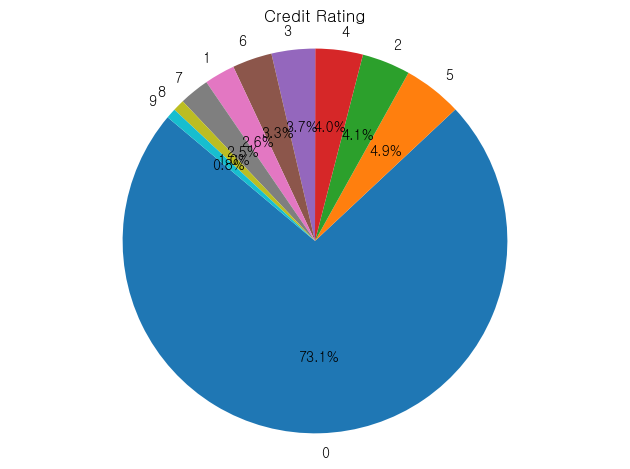

In [199]:
plot_imabalance(train_norm_sampled, 'rainfall_train.class_interval')

In [200]:
syn_df_1 = generate_synthetic(model, minmax_list, False)

(250000, 58)


In [201]:
syn_df_2 = generate_synthetic(model, minmax_list, False)

(250000, 58)


In [202]:
minority_syn_df = pd.DataFrame()
for i in range(6):
    syn_df = generate_synthetic(model, minmax_list, True, 8, 9)
    minority_syn_df = pd.concat([minority_syn_df, syn_df], axis=0)

(17328, 58)
(17140, 58)
(17337, 58)
(17348, 58)
(17312, 58)
(17489, 58)


In [203]:
minority_syn_df2 = pd.DataFrame()
for i in range(1):
    syn_df = generate_synthetic(model, minmax_list, True, 1, 7)
    minority_syn_df2 = pd.concat([minority_syn_df2, syn_df], axis=0)

(40695, 58)


In [204]:
minority_syn_df3 = pd.DataFrame()
for i in range(1):
    syn_df = generate_synthetic(model, minmax_list, True, 6, 9)
    minority_syn_df3 = pd.concat([minority_syn_df3, syn_df], axis=0)

(43081, 58)


In [205]:
balance_df = pd.DataFrame(pd.concat([train_norm_sampled, minority_syn_df], axis=0))

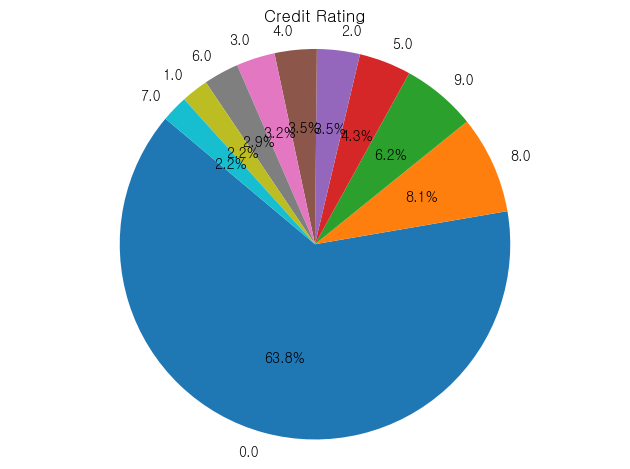

In [206]:
plot_imabalance(balance_df, 'rainfall_train.class_interval')

In [207]:
def plot_balance(syn_df):
    global balance_df
    balance_df = pd.DataFrame(pd.concat([balance_df, syn_df['rainfall_train.class_interval']], axis=0))
    plot_imabalance(balance_df, 'rainfall_train.class_interval')
    print(balance_df.shape)

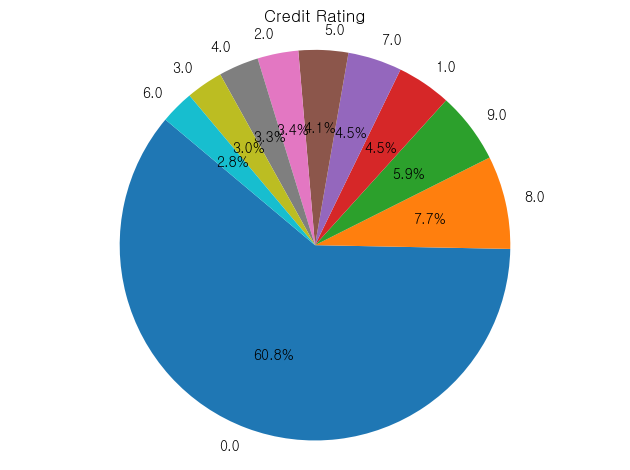

(860250, 58)


In [208]:
plot_balance(minority_syn_df2)

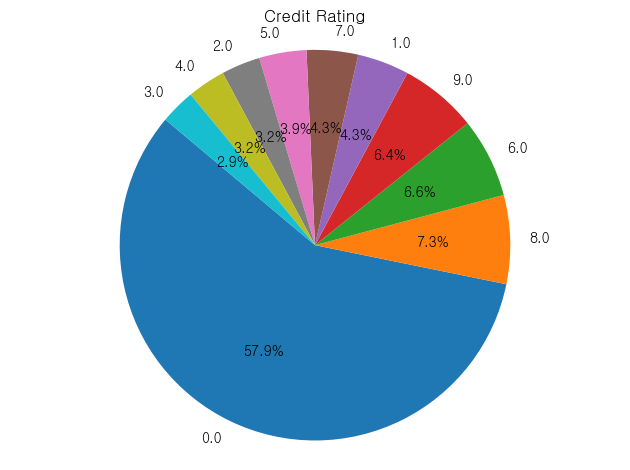

(903331, 58)


In [209]:
plot_balance(minority_syn_df3)

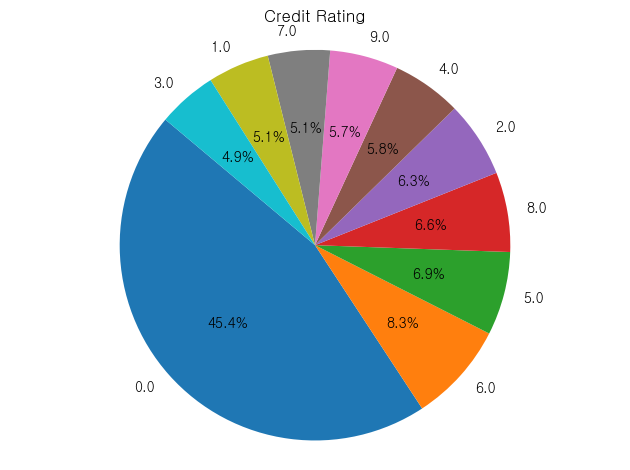

(1153331, 58)


In [210]:
plot_balance(syn_df_1)

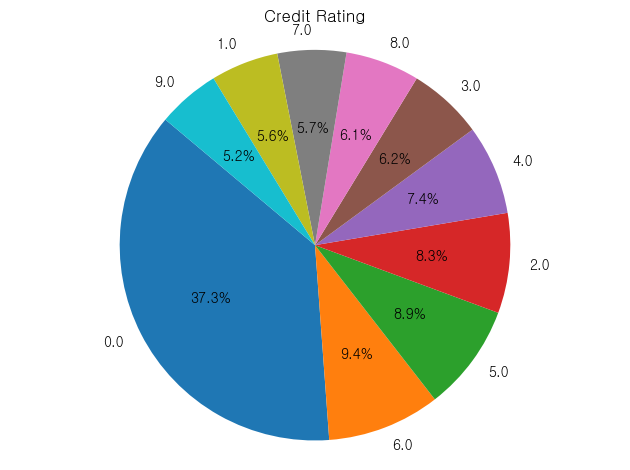

(1403331, 58)


In [211]:
plot_balance(syn_df_2)

In [214]:
final_df = pd.concat(
    [train_norm_sampled, syn_df_1, syn_df_2, minority_syn_df, minority_syn_df2, minority_syn_df3], axis=0)

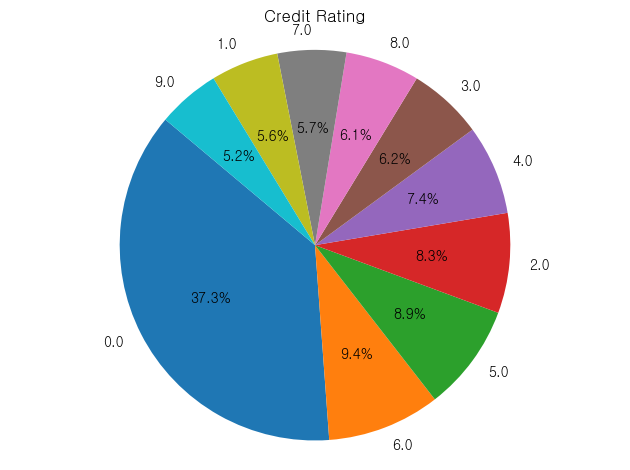

In [215]:
plot_imabalance(pd.DataFrame(final_df['rainfall_train.class_interval']), 'rainfall_train.class_interval')

# 지역별 분리

In [94]:
# X_train_norm_dict = {}
# y_train_norm_dict = {}
# 
# for i, STN in enumerate(df['rainfall_train.stn4contest'].unique().tolist()):
#     train_mask = (X_train_norm['rainfall_train.stn4contest'] == STN)
#     X_train_norm_dict[STN] = X_train_norm[train_mask]
#     y_train_norm_dict[STN] = pd.DataFrame(y_train_norm)[train_mask]
# 
# for i, (key, value) in enumerate(X_train_norm_dict.items()):
#     X_train_norm_dict[key] = value.iloc[:, 1:]
# 
# X_val_norm = X_val_norm.iloc[:, 1:]
# X2 = X2.iloc[:, 1:]

# GMM분리

In [117]:
# GMM = joblib.load('Database/gmm_model.pkl')
# 
# balanced_X_train_norm = final_df.drop(columns=['rainfall_train.class_interval'])
# balanced_y_train = final_df['rainfall_train.class_interval']
# X_train_norm = pd.concat(
#     [balanced_X_train_norm, pd.DataFrame(GMM.predict(final_df), index=balanced_X_train_norm.index)],
#     axis=1)
# 
# X_train_norm_dict = {}
# y_train_dict = {}
# 
# for i, cluster_num in enumerate(X_train_norm[0].unique().tolist()):
#     train_mask = (X_train_norm[0] == cluster_num)
#     X_train_norm_dict[cluster_num] = X_train_norm[train_mask]
#     y_train_dict[cluster_num] = pd.DataFrame(balanced_y_train)[train_mask]
#     X_train_norm_dict[cluster_num] = X_train_norm_dict[cluster_num].drop(columns=0)

# Random 3분할

In [216]:
splits = []
current_data = final_df
num_splits = 20

for _ in range(num_splits - 1):
    split1, split2 = train_test_split(current_data, test_size=1/(num_splits - len(splits)), shuffle=True, random_state=42)
    splits.append(split2)
    current_data = split1

splits.append(current_data)

for i, split in enumerate(splits):
    print(f"Split {i+1}: {split.shape[0]} samples")

Split 1: 70167 samples
Split 2: 70167 samples
Split 3: 70167 samples
Split 4: 70167 samples
Split 5: 70167 samples
Split 6: 70167 samples
Split 7: 70167 samples
Split 8: 70167 samples
Split 9: 70167 samples
Split 10: 70167 samples
Split 11: 70167 samples
Split 12: 70166 samples
Split 13: 70166 samples
Split 14: 70166 samples
Split 15: 70166 samples
Split 16: 70166 samples
Split 17: 70166 samples
Split 18: 70166 samples
Split 19: 70166 samples
Split 20: 70166 samples


In [217]:
X_train_norm_dict = {}
y_train_dict = {}

for i, train in enumerate(splits):
    X_train_norm_dict[i] =train.drop(columns=['rainfall_train.class_interval'])
    y_train_dict[i] = pd.DataFrame(train['rainfall_train.class_interval'])

In [218]:
for i, (key, value) in enumerate(X_train_norm_dict.items()):
    print(f'{key} Train set')
    print(value.shape)
    print(y_train_dict[key].shape)

print('Validation set')
print(X_val_norm.shape)
print(y_val.shape)

print('Test set')
print(X2.shape)

if self_test:
    print(y2.shape)

0 Train set
(70167, 57)
(70167, 1)
1 Train set
(70167, 57)
(70167, 1)
2 Train set
(70167, 57)
(70167, 1)
3 Train set
(70167, 57)
(70167, 1)
4 Train set
(70167, 57)
(70167, 1)
5 Train set
(70167, 57)
(70167, 1)
6 Train set
(70167, 57)
(70167, 1)
7 Train set
(70167, 57)
(70167, 1)
8 Train set
(70167, 57)
(70167, 1)
9 Train set
(70167, 57)
(70167, 1)
10 Train set
(70167, 57)
(70167, 1)
11 Train set
(70166, 57)
(70166, 1)
12 Train set
(70166, 57)
(70166, 1)
13 Train set
(70166, 57)
(70166, 1)
14 Train set
(70166, 57)
(70166, 1)
15 Train set
(70166, 57)
(70166, 1)
16 Train set
(70166, 57)
(70166, 1)
17 Train set
(70166, 57)
(70166, 1)
18 Train set
(70166, 57)
(70166, 1)
19 Train set
(70166, 57)
(70166, 1)
Validation set
(65194, 57)
(65194,)
Test set
(144897, 57)
(144897,)


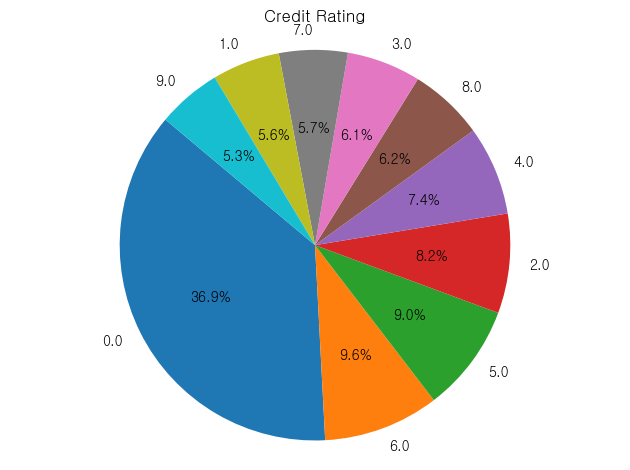

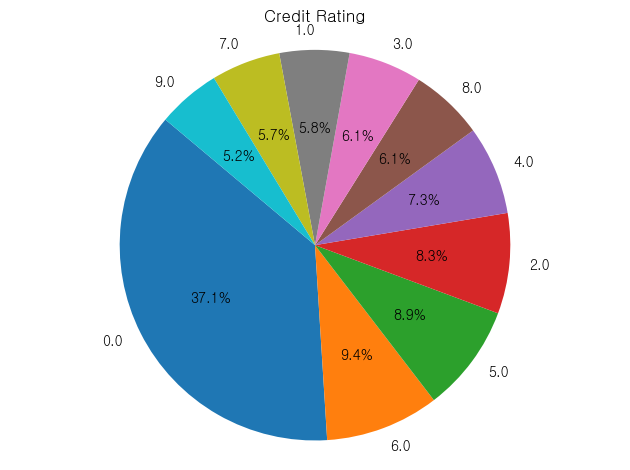

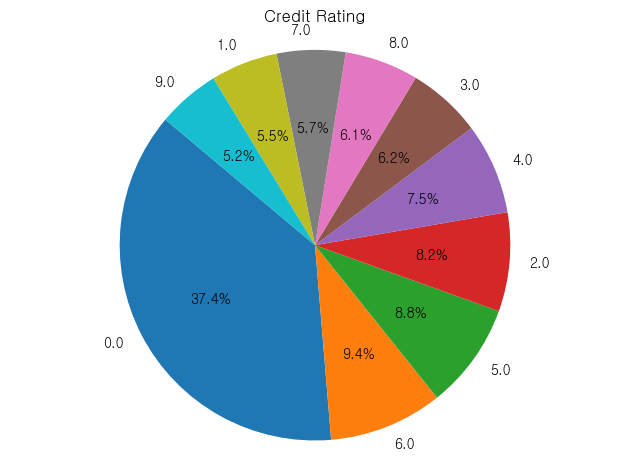

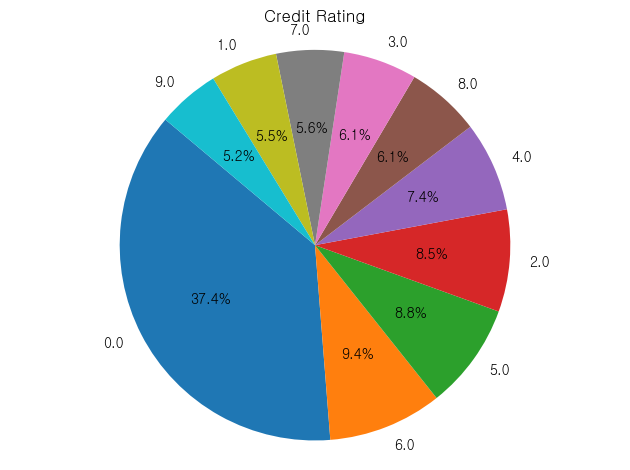

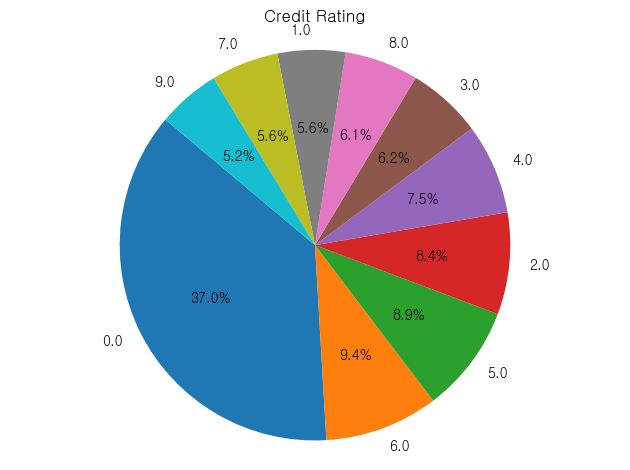

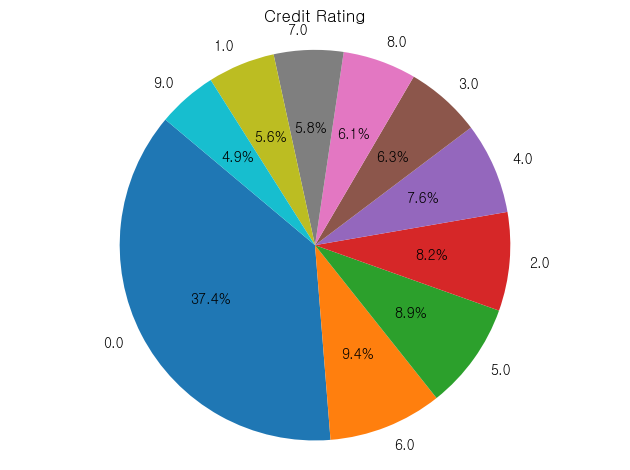

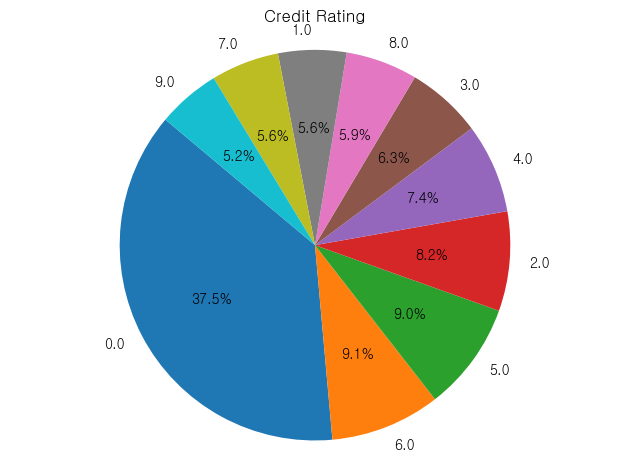

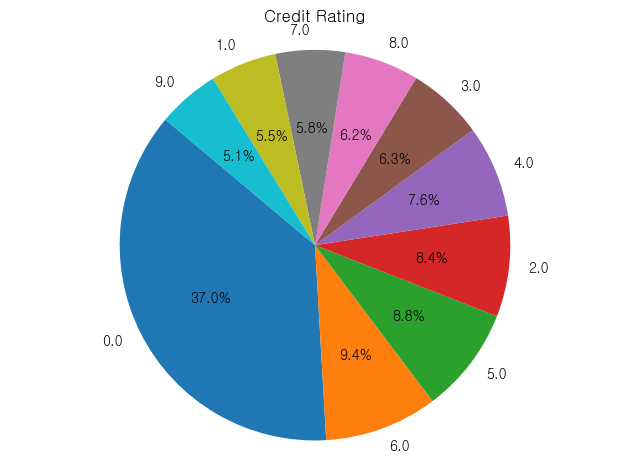

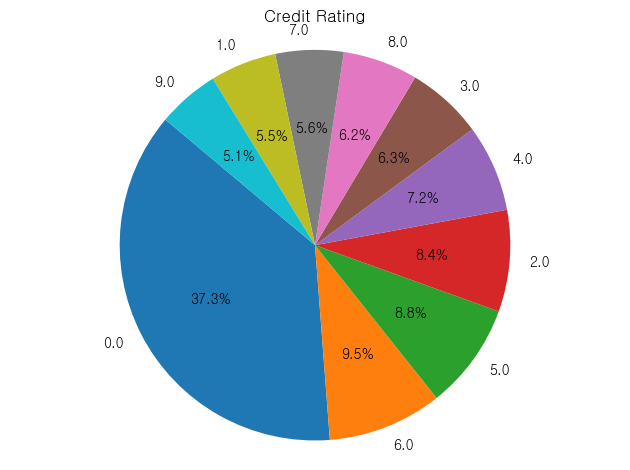

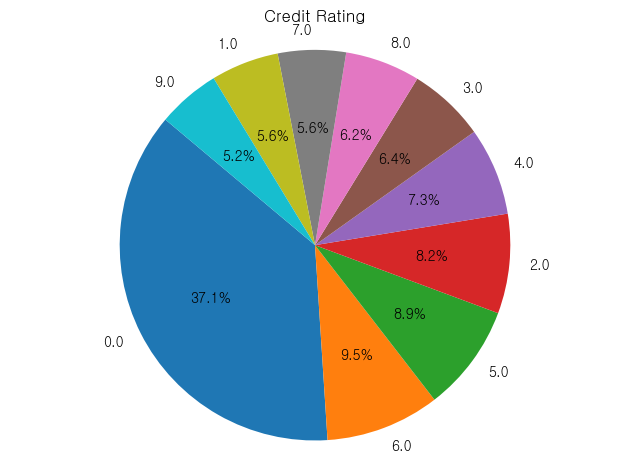

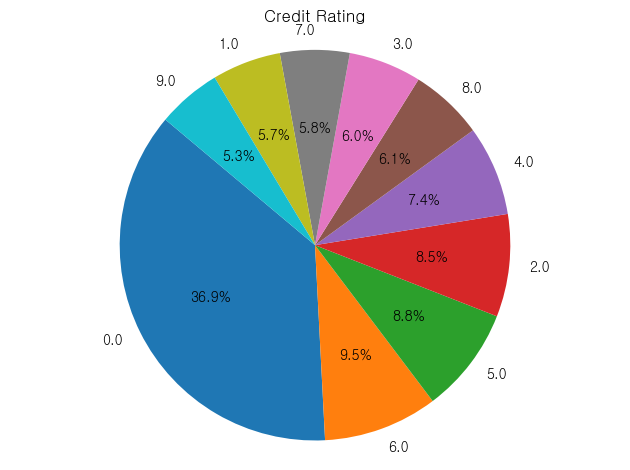

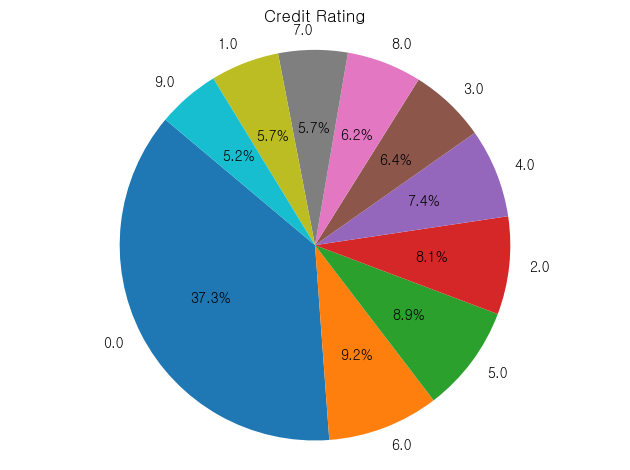

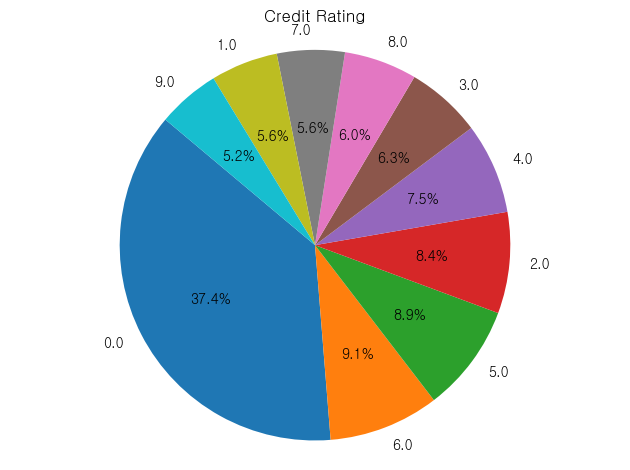

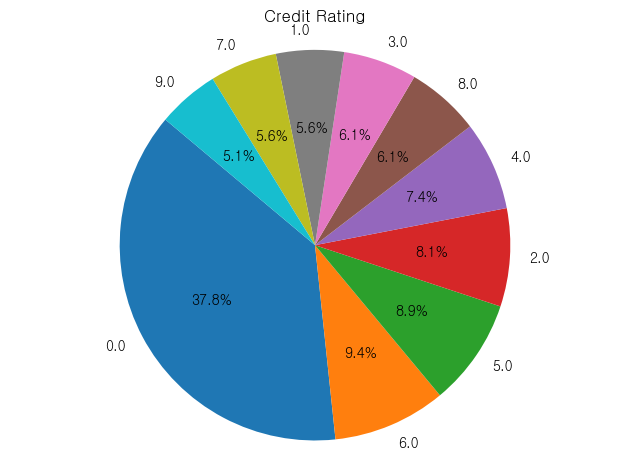

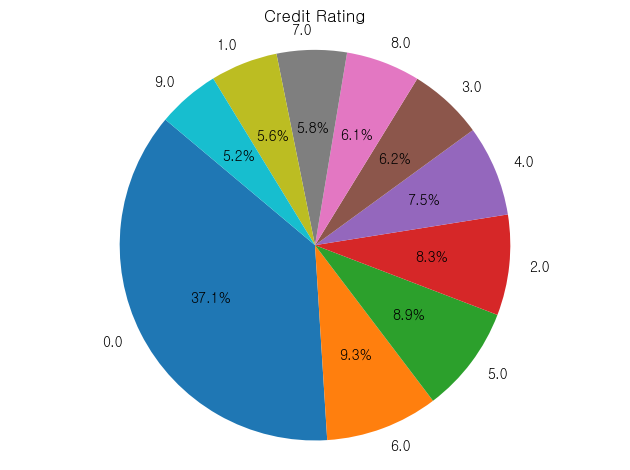

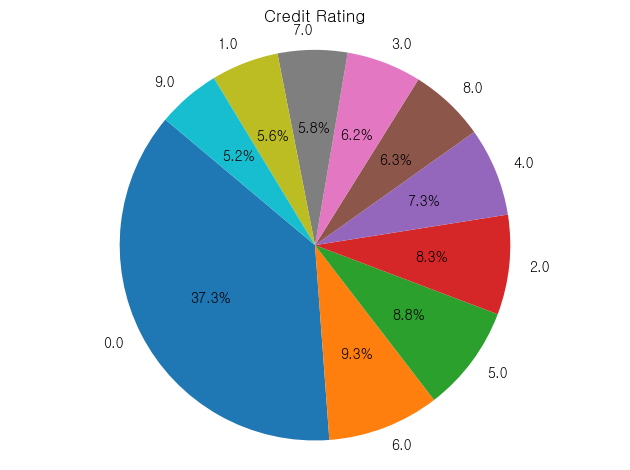

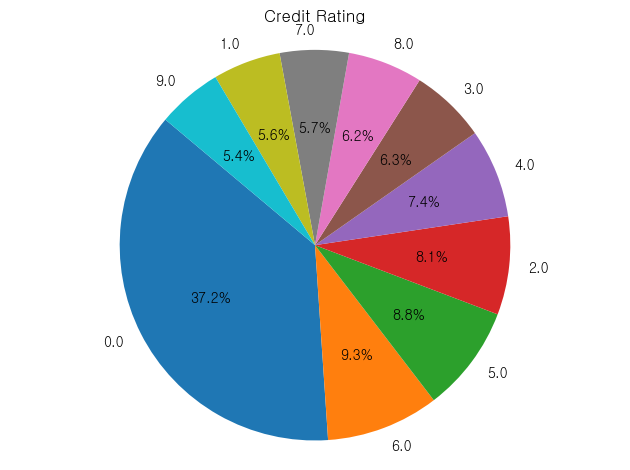

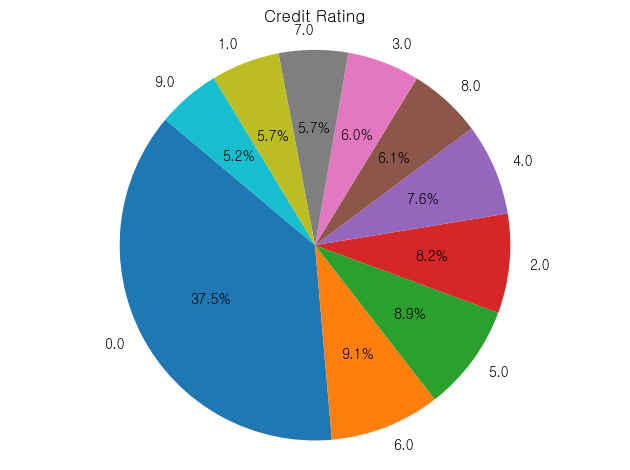

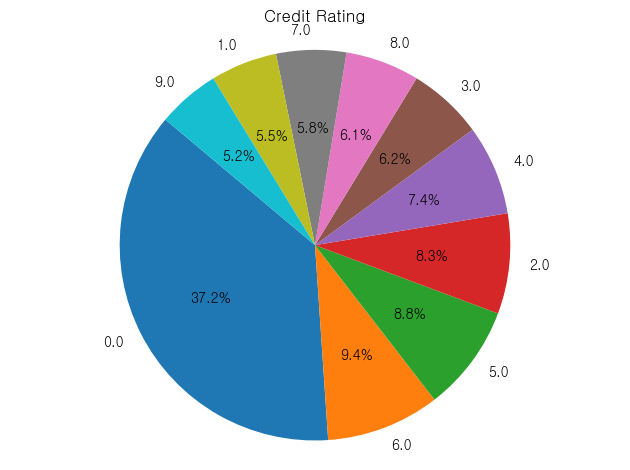

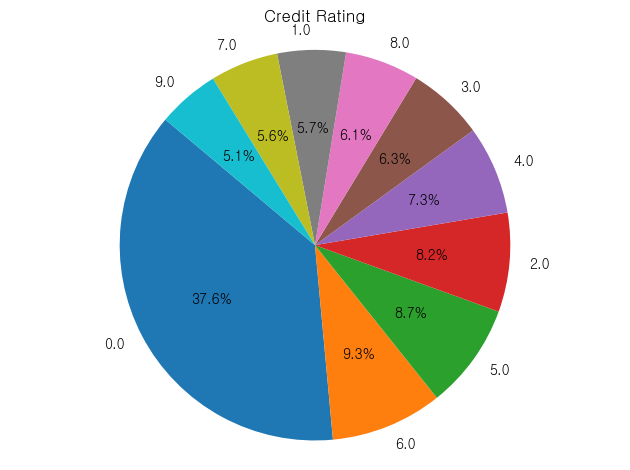

In [219]:
for i in range(20):
    plot_imabalance(pd.DataFrame(y_train_dict[i]), 'rainfall_train.class_interval')

# 전처리 파일저장

In [220]:
for i, (key, value) in enumerate(X_train_norm_dict.items()):
    value.to_csv(f'Database/train/Random{key}_X_train_norm.csv')
    y_train_dict[key].to_csv(f'Database/train/Random{key}_y_train.csv')
    print(f'Random{key} Train set saved!')

X_val_norm.to_csv(f'Database/val/X_val_norm.csv')
y_val.to_csv(f'Database/val/y_val.csv')
print('Validation set saved!')

if self_test:
    X2.to_csv(f'Database/test/X_self_test_norm.csv')
    y2.to_csv(f'Database/test/y_self_test.csv')

if not self_test:
    X2.to_csv(f'Database/test/X_real_test_norm.csv')
print('Test set saved!')

Random0 Train set saved!
Random1 Train set saved!
Random2 Train set saved!
Random3 Train set saved!
Random4 Train set saved!
Random5 Train set saved!
Random6 Train set saved!
Random7 Train set saved!
Random8 Train set saved!
Random9 Train set saved!
Random10 Train set saved!
Random11 Train set saved!
Random12 Train set saved!
Random13 Train set saved!
Random14 Train set saved!
Random15 Train set saved!
Random16 Train set saved!
Random17 Train set saved!
Random18 Train set saved!
Random19 Train set saved!
Validation set saved!
Test set saved!
